# Deep Learning for MNIST Dataset Classification
In this notebook, we attempt to implement three models using the PyTorch Framework: A Logistic Regression Model (Softmax), a Multi-Layer Perceptron, and a CNN (LeNet). All the models will be fit to the MNIST handwritten digits dataset for digit recognition.

We start by importing some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,transforms

We load the MNIST Dataset from torchvision and split into train, test and validation sets:

In [2]:
#Load MNIST Dataset from torchvision datasets
#We Apply transformation to convert the data from PIL images to Tensors
train_set = datasets.MNIST(root='./mnist', train=True, transform=transforms.ToTensor(), download=True)
test_set = datasets.MNIST(root='./mnist', train=False, transform=transforms.ToTensor(), download=True)
#Split train into train + val sets (50k, 10k)
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

## (1) Softmax Regression using PyTorch

We start by implementing a simple logistic regression model on the dataset. The dataset has images of 28x28 and 10 classes (digits 0-9). We will use the PyTorch dataloader to help batch our data for processing. We will then define our model class to represent the Logistic Regression Model. We will also define some helper functions to train the model and evaluate the performance:

In [3]:
#Initialize dataloader to batch data
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size)

#Helper Function to calculate accuracy of output wrt labels
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#Define model class
class SoftmaxRegressionModel(torch.nn.Module):
    #Initialize method
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(28*28, 10) #Linear Layer with input shape 784, output shape 10
    #Forward method
    def forward(self, xb):
        xb = xb.reshape(-1, 784) #Flatten image into (Batch size x 784)
        out = self.linear(xb)
        return out
    #Function to perform a training step
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels) # Calculate loss
        return loss
    #Function to perform validation step
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    #Function to calculate val loss/acc across validation batches
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]    
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    #Function to print epoch end results
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

#Function to evaluate model on Validation data
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#Function to perform training loop
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    #Define Optimizer
    optimizer = opt_func(model.parameters(), lr)
    #Variable to store best Validation Accuracy
    best_val_acc = 0
    #Iterate epochs
    for epoch in range(epochs):
        #Training Phase 
        #Iterate batches
        for batch in train_loader:
            #Calculate loss by performing forward pass
            loss = model.training_step(batch)
            #Perform backward step to get gradients
            loss.backward()
            #Update weights of model
            optimizer.step()
            #Reset gradients to zero for next round
            optimizer.zero_grad()
        #Validation phase - Check model acc/loss on val set
        result = evaluate(model, val_loader)
        #Print Metrics
        model.epoch_end(epoch, result)
        #Add to history to plot curve once done
        history.append(result)
        if result['val_acc'] > best_val_acc:
            #Update best validation accuracy and save model
            best_val_acc = result['val_acc']
            torch.save(model.state_dict(), './best_models/SoftmaxRegressionModel.pt')
    return history

        

Now, we initialize and train the model. We train for 10 epochs with a learning rate of 1e-3. Our dataloader will help feed batches of size = 32 into our training loop. We will also plot the Validation Accuracy and Validation loss after the training is complete:

Epoch [0], val_loss: 1.3281, val_acc: 0.7883
Epoch [1], val_loss: 0.9814, val_acc: 0.8238
Epoch [2], val_loss: 0.8193, val_acc: 0.8380
Epoch [3], val_loss: 0.7256, val_acc: 0.8497
Epoch [4], val_loss: 0.6639, val_acc: 0.8562
Epoch [5], val_loss: 0.6199, val_acc: 0.8598
Epoch [6], val_loss: 0.5867, val_acc: 0.8636
Epoch [7], val_loss: 0.5606, val_acc: 0.8673
Epoch [8], val_loss: 0.5393, val_acc: 0.8707
Epoch [9], val_loss: 0.5217, val_acc: 0.8727


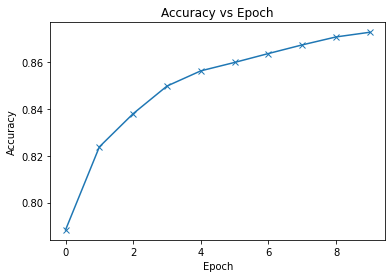

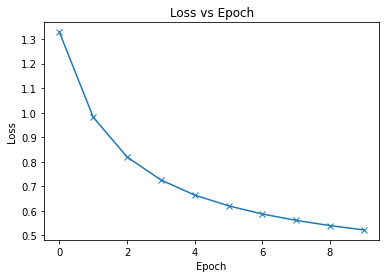

In [4]:
#Initialize model
model = SoftmaxRegressionModel()
#Training model
history = fit(epochs=10, lr=1e-3, model=model, train_loader=train_loader, val_loader=val_loader)
#Plot Validation Accuracy Curve
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.show()
#Plot Validation Loss Curve
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

Our model achieves ~87% Accuracy on the validation set. We will also evaluate our model on the MNIST Test Set. We re-use the evaluate function that we defined earlier:

In [5]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size)
test_result = evaluate(model, test_loader)
print('Test Accuracy: ', test_result['val_acc'])

Test Accuracy:  0.8803913593292236


We can also display some images along with our model's predicted labels:

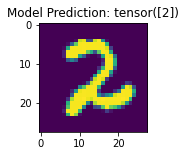

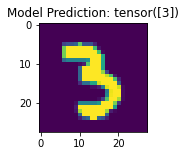

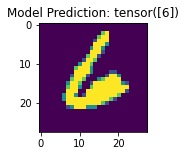

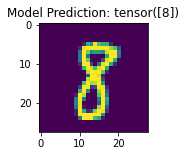

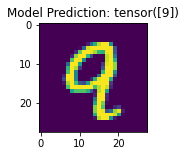

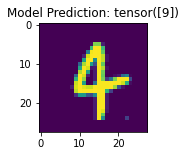

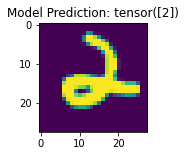

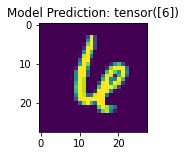

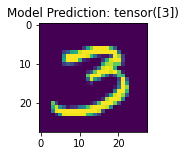

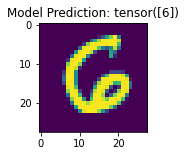

In [6]:
test_loader = torch.utils.data.DataLoader(test_set, 10, shuffle=True)
#Just pick the first random batch 
random_test_batch = next(iter(test_loader))
random_X, random_Y = random_test_batch
for i in range(10):
    image = random_X[i]
    label = random_Y[i]
    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape((28, 28)))
    plt.title('Model Prediction: '+str(pred))
    plt.show()

Our train function saves the best model based on the validation accuracy. We can load the best model and evaluate it on the test set:

In [7]:
#Initialize new model
new_Model = SoftmaxRegressionModel()
#Load parameters that were saved
new_Model.load_state_dict(torch.load('./best_models/SoftmaxRegressionModel.pt'))
#Evaluate Accuracy
test_result = evaluate(new_Model, test_loader)
print('Test Accuracy after loading best model: ', test_result['val_acc'])

Test Accuracy after loading best model:  0.8805999755859375


## (2) Multi-Layer Perceptron using PyTorch
In this section, we implement a MLP using PyTorch. We define the model as a class similar to the previous section, inheriting the torch.nn.Module class. The class will contain a nn.ModuleList() which will be used to store a variable number of layers. Our model constructor will accept an array with the list of hidden layers (units) e.g. [64, 32, 28].

In [11]:
#Define Model Class
class MLP(torch.nn.Module):
    #Initialize method
    def __init__(self, hidden_layer_dims):
        super(MLP, self).__init__()
        self.layers = torch.nn.ModuleList()
        #Iterate through hidden layer dims and append a new linear layer
        input_dim = 28*28
        for hidden_dim in hidden_layer_dims:
            self.layers.append(torch.nn.Linear(input_dim, hidden_dim))
            input_dim = hidden_dim
        #Add final output layer
        self.layers.append(torch.nn.Linear(input_dim, 10))
        print('*'*10, 'Initializing Model...', '*'*10)
        print(self.layers)
    
    #Forward function
    def forward(self, x):
        #Flatten input 
        out = x.reshape(-1, 784)
        #Iterate through hidden layers
        for i in range(len(self.layers) - 1):
            layer = self.layers[i]
            #Apply relu on linear output
            out = torch.nn.functional.relu(layer(out))
        #Final output layer
        output_layer = self.layers[-1]
        out = output_layer(out)
        return out
    
    #Function to perform training step
    def training_step(self, batch):
        images, labels = batch 
        out = self(images) # Generate predictions (do forward pass)
        loss = torch.nn.functional.cross_entropy(out, labels) # Calculate loss
        return loss
    
    #Function to perform validation step
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images) # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    #Function to calculate val loss/acc across validation batches
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]    
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    #Function to print epoch end results
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
#Function to evaluate model on Validation data
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#Function to perform training loop
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    #Define Optimizer
    optimizer = opt_func(model.parameters(), lr)
    #Variable to store best Validation Accuracy
    best_val_acc = 0
    #Iterate epochs
    for epoch in range(epochs):
        #Training Phase 
        #Iterate batches
        for batch in train_loader:
            #Calculate loss by performing forward pass
            loss = model.training_step(batch)
            #Perform backward step to get gradients
            loss.backward()
            #Update weights of model
            optimizer.step()
            #Reset gradients to zero for next round
            optimizer.zero_grad()
        #Validation phase - Check model acc/loss on val set
        result = evaluate(model, val_loader)
        #Print Metrics
        model.epoch_end(epoch, result)
        #Add to history to plot curve once done
        history.append(result)
        if result['val_acc'] > best_val_acc:
            #Update best validation accuracy and save model
            best_val_acc = result['val_acc']
            torch.save(model.state_dict(), './best_models/MLPModel.pt')
    return history

Now that we have our model class and helper functions, we will initialize and train the model. For this exercise, we use an architecture of 3 hidden layers of [512, 256, 128] units respectively. The output layer will contain 10 units as usual since there are 10 classes in the MNIST dataset. This time, we will train for 50 epochs with a learning rate of 1e-3 since we have many more parameters. Our fit() function also continuously saves the best model based on the validation accuracy:

********** Initializing Model... **********
ModuleList(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=256, bias=True)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): Linear(in_features=128, out_features=10, bias=True)
)
********** Training model... **********
Epoch [0], val_loss: 2.2920, val_acc: 0.1702
Epoch [1], val_loss: 2.2766, val_acc: 0.3020
Epoch [2], val_loss: 2.2494, val_acc: 0.4519
Epoch [3], val_loss: 2.1946, val_acc: 0.5843
Epoch [4], val_loss: 2.0670, val_acc: 0.6123
Epoch [5], val_loss: 1.7450, val_acc: 0.6343
Epoch [6], val_loss: 1.2412, val_acc: 0.6960
Epoch [7], val_loss: 0.9126, val_acc: 0.7493
Epoch [8], val_loss: 0.7429, val_acc: 0.7846
Epoch [9], val_loss: 0.6405, val_acc: 0.8134
Epoch [10], val_loss: 0.5724, val_acc: 0.8358
Epoch [11], val_loss: 0.5214, val_acc: 0.8513
Epoch [12], val_loss: 0.4845, val_acc: 0.8618
Epoch [13], val_loss: 0.4561, val_acc: 0.8690
Epoch [14], val_loss: 0.4327,

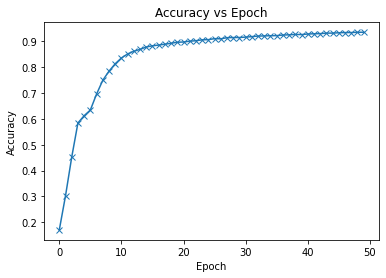

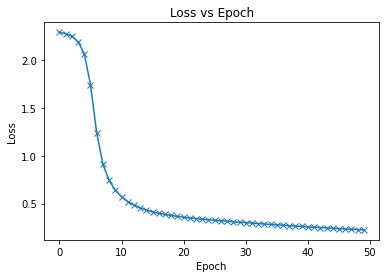

In [12]:
#Initialize model
mlp_model = MLP([512,256,128])
#Train the model
print('*'*10, 'Training model...', '*'*10)
mlp_history = fit(50, lr=1e-3, model=mlp_model, train_loader=train_loader, val_loader=val_loader)
#Plot validation loss/accuracy curves
accuracies = [result['val_acc'] for result in mlp_history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.show()

losses = [result['val_loss'] for result in mlp_history]
plt.plot(losses, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

Our model achieves significantly more accuracy on the validation set (~93%) compared to the logistic regression model (~87%). We also evaluate the MLP model on the mnist test set:

In [13]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size)
test_result = evaluate(mlp_model, test_loader)
print('Test Accuracy: ', test_result['val_acc'])

Test Accuracy:  0.9393969774246216


We again pick 10 random images and display our MLP's prediction:

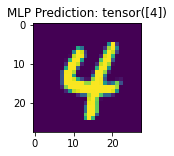

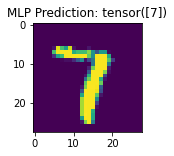

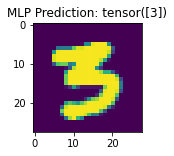

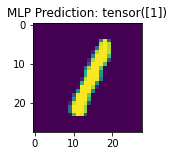

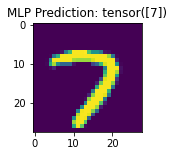

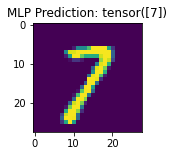

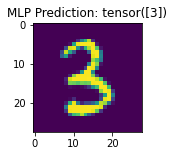

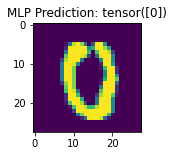

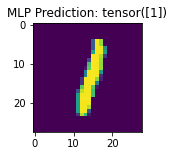

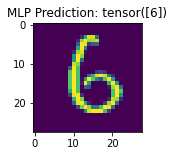

In [14]:
#Define a dataloader to get a batch of test data of size 10 (Shuffle=True so this will be a random batch)
test_loader = torch.utils.data.DataLoader(test_set, 10, shuffle=True)
#Just pick the first random batch 
random_test_batch = next(iter(test_loader))
random_X, random_Y = random_test_batch
for i in range(10):
    image = random_X[i]
    label = random_Y[i]
    pred = mlp_model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape((28, 28)))
    plt.title('MLP Prediction: '+str(pred))
    plt.show()

Finally, we load our best model from the parameters file that was saved during our training, and evaluate the test set again:

In [16]:
#Initialize new model
new_MLP_Model = MLP([512, 256, 128])
#Load parameters that were saved
new_MLP_Model.load_state_dict(torch.load('./best_models/MLPModel.pt'))
#Evaluate Accuracy
test_result = evaluate(new_MLP_Model, test_loader)
print('Test Accuracy after loading best model: ', test_result['val_acc'])

********** Initializing Model... **********
ModuleList(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=256, bias=True)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): Linear(in_features=128, out_features=10, bias=True)
)
Test Accuracy after loading best model:  0.9393998980522156


## (3) LeNet (CNN) implementation using PyTorch
In this final section, we implement a variant of 'LeNet', a simple Convolutional Net (CNN) first proposed by LeCun et al. in 1998. It will have two convolutional layers, followed by a fully-connected (FC) layer and an output layer with the number of classes. We define our model class similar to the previous sections:

In [31]:
class LeNet(torch.nn.Module):
    #Initialize function
    def __init__(self):
        super().__init__()
        #Define Convolutional layers first
        self.convLayers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=5, padding='same', stride=1),     #Conv2d layer, input = 28x28x1, output = 28x28x32
            torch.nn.ReLU(),                                                #ReLU non-linearity 
            torch.nn.MaxPool2d(2),                                          #MaxPool layer, input = 28x28x32, output = 14x14x32
            torch.nn.Conv2d(32, 64, kernel_size=5, padding='same', stride=1),    #Conv2d layer, input = 14x14x32, output = 14x14x64
            torch.nn.ReLU(),                                                #ReLU non-linearlity
            torch.nn.MaxPool2d(2)                                           #MaxPool layer, input = 14x14x64, output = 7x7x64
        )
        #Next, define the FC layers
        self.fcLayers = torch.nn.Sequential(
            torch.nn.Linear(7*7*64, 1024),                                  #FC Layer, input = 7*7*64 = 3136, output = 1024
            torch.nn.ReLU(),                                                #ReLU non-linearlity
            torch.nn.Linear(1024,10)                                        #FC (Output) Layer, input = 1024, output = 10 (no. of classes)
        )
        print('*'*10, 'Initializing model...', '*'*10)
        print(self.convLayers)
        print(self.fcLayers)
    
    #Forward function
    def forward(self, x):
        #First pass the image to convolutional layers (no need to reshape, conv2d accepts the 28x28x1 image)
        out = self.convLayers(x)
        #Flatten output to feed to FC Layers
        out = torch.flatten(out, 1)
        #Feed output to FC Layers
        out = self.fcLayers(out)
        return out
    
    #Function to perform training step
    def training_step(self, batch):
        images, labels = batch 
        out = self(images) # Generate predictions (do forward pass)
        loss = torch.nn.functional.cross_entropy(out, labels) # Calculate loss
        return loss

    #Function to perform validation step
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images) # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    #Function to calculate val loss/acc across validation batches
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]    
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    #Function to print epoch end results
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

#Function to evaluate model on Validation data
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#Function to perform training loop
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    #Define Optimizer
    optimizer = opt_func(model.parameters(), lr)
    #Variable to store best Validation Accuracy
    best_val_acc = 0
    #Iterate epochs
    for epoch in range(epochs):
        #Training Phase 
        #Iterate batches
        for batch in train_loader:
            #Calculate loss by performing forward pass
            loss = model.training_step(batch)
            #Perform backward step to get gradients
            loss.backward()
            #Update weights of model
            optimizer.step()
            #Reset gradients to zero for next round
            optimizer.zero_grad()
        #Validation phase - Check model acc/loss on val set
        result = evaluate(model, val_loader)
        #Print Metrics
        model.epoch_end(epoch, result)
        #Add to history to plot curve once done
        history.append(result)
        if result['val_acc'] > best_val_acc:
            #Update best validation accuracy and save model
            best_val_acc = result['val_acc']
            torch.save(model.state_dict(), './best_models/CNN.pt')
    return history

Now that we have our CNN class defined along with the helper functions, we will train the model. This time we will use the Adam Optimizer and train with a learning rate of 1e-3 for 5 epochs. We re-use the train/validation dataloaders that we defined in the earlier sections:

********** Initializing model... **********
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Linear(in_features=3136, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=10, bias=True)
)
********** Training model... **********
Epoch [0], val_loss: 0.0426, val_acc: 0.9878
Epoch [1], val_loss: 0.0396, val_acc: 0.9874
Epoch [2], val_loss: 0.0368, val_acc: 0.9894
Epoch [3], val_loss: 0.0352, val_acc: 0.9902
Epoch [4], val_loss: 0.0382, val_acc: 0.9898


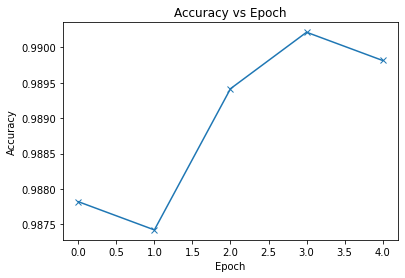

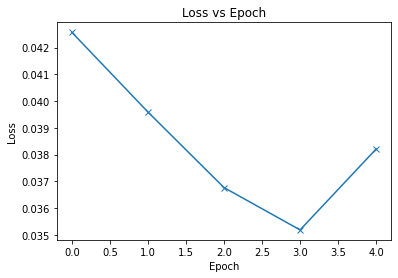

In [36]:
#Initialize model
cnn_model = LeNet()

#Train the model
print('*'*10, 'Training model...', '*'*10)
cnn_history = fit(5, lr=1e-3, model=cnn_model, train_loader=train_loader, val_loader=val_loader, opt_func=torch.optim.Adam)
#Plot validation loss/accuracy curves
accuracies = [result['val_acc'] for result in cnn_history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.show()

losses = [result['val_loss'] for result in cnn_history]
plt.plot(losses, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

The CNN model achieves the highest accuracy out of the 3 models (~98%). We also evaluate the model on the test set:

In [37]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size)
test_result = evaluate(cnn_model, test_loader)
print('Test Accuracy: ', test_result['val_acc'])

Test Accuracy:  0.9920127987861633


Our CNN model achieved a 99.2% accuracy on the test set. We sample 10 images and display our model's predicted output:

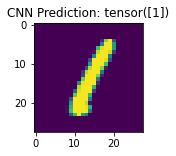

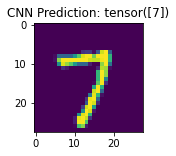

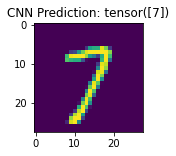

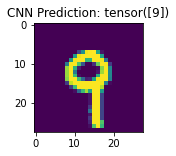

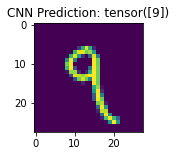

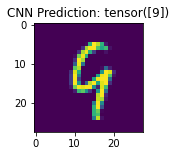

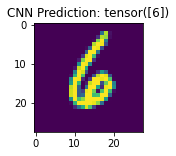

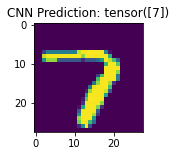

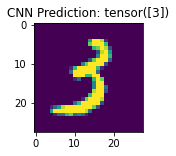

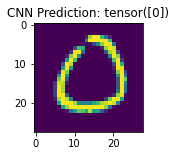

In [42]:
#Define a dataloader to get a batch of test data of size 10 (Shuffle=True so this will be a random batch)
test_loader = torch.utils.data.DataLoader(test_set, 10, shuffle=True)
#Just pick the first random batch 
random_test_batch = next(iter(test_loader))
random_X, random_Y = random_test_batch
for i in range(10):
    image = random_X[i]
    label = random_Y[i]
    pred = cnn_model(torch.unsqueeze(image, 0))
    pred = torch.nn.functional.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape((28, 28)))
    plt.title('CNN Prediction: '+str(pred))
    plt.show()

Finally, we load the best model (on the validation set) saved during our training, and evaluate it again on the test set:

In [43]:
#Initialize new model
new_CNN_Model = LeNet()
#Load parameters that were saved
new_CNN_Model.load_state_dict(torch.load('./best_models/CNN.pt'))
#Evaluate Accuracy
test_result = evaluate(new_CNN_Model, test_loader)
print('Test Accuracy after loading best model: ', test_result['val_acc'])

********** Initializing model... **********
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Linear(in_features=3136, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=10, bias=True)
)
Test Accuracy after loading best model:  0.9918000102043152
